<a href="https://colab.research.google.com/github/rifatcakir/data_science_nutritions/blob/main/EnglishVsMandarin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

## Installations

In [1]:
!pip install arviz
!pip install pymc3==3.8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')

## Data Loads

I am accesing data files from my github page.

In [2]:
datE = pd.read_csv("https://raw.githubusercontent.com/rifatcakir/Bayesian-data-analysis-in-the-phonetic-sciences/main/data/english.txt", delimiter="\t")

datM = pd.read_csv("https://raw.githubusercontent.com/rifatcakir/Bayesian-data-analysis-in-the-phonetic-sciences/main/data/songyuan.txt", delimiter="\t")

datE.head() 


,utt,subject,gender,StartTime,EndTime,Item,WorldBet,TargetConsonant,TargetVowel,Burst,VOT,VowelEnd,Notes,msVOT,msVowel,logVOT,logVowel,vOff,vOn
0,e9gt01mw_enrw121,e9gt01mw,m,31.689451,32.531513,dnky4,dAn.ki,d,A,31.932228,31.945853,32.073128,NaN,13.625061,140.900013,2.611911,4.948051,NaN,NaN
1,e9gt01mw_enrw121,e9gt01mw,m,34.651535,35.587680,door5,do9,d,o,34.997306,35.007174,35.224838,NaN,9.867827,227.531612,2.289280,5.427289,NaN,NaN
2,e9gt01mw_enrw121,e9gt01mw,m,49.620381,50.479756,tnge5,th^N,th,^,49.793717,49.860658,50.061312,NaN,66.940813,267.595631,4.203809,5.589477,NaN,NaN
3,e9gt01mw_enrw121,e9gt01mw,m,56.293206,56.905279,qwil4,kwhIl,kwh,I,56.359330,56.444342,56.661644,NaN,85.012193,302.313780,4.442795,5.711465,NaN,NaN
4,e9gt01mw_enrw121,e9gt01mw,m,59.744335,60.541886,cave3n,khev,kh,e,59.808561,59.868863,60.241512,NaN,60.301252,432.950305,4.099353,6.070623,NaN,NaN


In [3]:
datM.head()

,utt,subject,gender,StartTime,EndTime,Item,WorldBet,TargetConsonant,TargetVowel,Burst,VOT,VowelEnd,Notes,msVOT,msVowel,logVOT,logVowel
0,s9gt01fw_marw111,s9gt01fw,f,23.852289,24.961060,tnka3,tang2.kuai4,t,a,24.056383,24.138644,24.230231,lip/inhale burst @ 24.0564,82.260779,173.848081,4.409894,5.158182
1,s9gt01fw_marw111,s9gt01fw,f,36.549973,37.837578,duzi4,du4.zi,d,u,36.845960,36.855682,37.076299,NaN,9.722613,230.339275,2.274454,5.439553
2,s9gt01fw_marw111,s9gt01fw,f,58.153595,59.369667,dnzi3,ding1.zi,d,i,58.425046,58.435714,58.575377,NaN,10.668562,150.331600,2.367301,5.012844
3,s9gt01fw_marw111,s9gt01fw,f,60.943408,62.159480,tuzi5,tu4.zi,t,u,61.142675,61.244091,61.398042,microphone sound @ 61.1988,101.415942,255.367214,4.619230,5.542703
4,s9gt01fw_marw111,s9gt01fw,f,63.447085,64.484323,kuzi5,ku4.zi,k,u,63.664831,63.784175,63.931387,microphone sounds @ 63.7075,119.344099,266.556838,4.782011,5.585587


## PreProcess

### Mandarin

In [4]:
## voiceless stops -1, voiced stops +1:

datM["voiceN"] = np.where(datM["TargetConsonant"].isin(["t", "k"]), -1, 1)

datM["genderN"] = np.where(datM["gender"] == "f", .5, -.5)

datM["VOTN"] = round(datM["VOT"])

## Categorical Values 
datM["genSubN"] = (datM["gender"].add(datM["subject"])).astype("category").cat.codes

datM["worldBetN"] = datM.WorldBet.astype("category").cat.codes


datM = datM[["genSubN", "worldBetN", "subject", "gender", "genderN", "VOT", "msVowel", "voiceN"]]


datM_Renamed = datM.rename(columns={"WorldBet":"item", "gender":"genderfact", "genderN":"gender", "msVowel":"vduration"})

datM_Renamed = datM_Renamed[datM_Renamed["voiceN"] == -1]

datM_Renamed.head()


,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN
0,0,14,s9gt01fw,f,0.5,24.138644,173.848081,-1
3,0,19,s9gt01fw,f,0.5,61.244091,255.367214,-1
4,0,12,s9gt01fw,f,0.5,63.784175,266.556838,-1
6,0,11,s9gt01fw,f,0.5,94.100283,195.263651,-1
8,0,17,s9gt01fw,f,0.5,101.468401,212.920039,-1


### English

In [5]:
## voiceless stops -1, voiced stops +1:

datE["voiceN"] = np.where(datE["TargetConsonant"].isin(["kh", "kjh", "kwh", "th", "twh"]), -1, 1)

datE["genderN"] = np.where(datE["gender"] == "f", .5, -.5)

datE["VOTN"] = round(datE["VOT"])

## Categorical Values 
datE["genSubN"] = (datE["gender"].add(datE["subject"])).astype("category").cat.codes

datE["worldBetN"] = datE.WorldBet.astype("category").cat.codes


datE = datE[["genSubN", "worldBetN", "subject", "gender", "genderN", "VOT", "msVowel", "voiceN"]]


datE_Renamed = datE.rename(columns={"WorldBet":"item", "gender":"genderfact", "genderN":"gender", "msVowel":"vduration"})



datE_Renamed = datE_Renamed[datE_Renamed["voiceN"] == -1]

datE_Renamed.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN
2,10,49,e9gt01mw,m,-0.5,49.860658,267.595631,-1
3,10,41,e9gt01mw,m,-0.5,56.444342,302.313780,-1
4,10,30,e9gt01mw,m,-0.5,59.868863,432.950305,-1
5,10,39,e9gt01mw,m,-0.5,69.763520,156.066285,-1
8,10,54,e9gt01mw,m,-0.5,88.775660,219.483993,-1


# Question 1

Gender on VOT in long-lag stops

We are going to use posterior distribution.

## Mandorin Model

In [5]:
genderModel={
    "VOT": ["developer"],
    "gender": ["developer"]
}

In [27]:
with pm.Model() as man_gender_model:
  b = pm.Normal("b", 0., 50.)
  sd = pm.Normal("sd", 0., 100.)
  sigma = pm.Exponential("sigma", 1)
  a = pm.Normal("a", 0, 200)

  vot_hat = pm.Deterministic("vot_hat", a + b*datM_Renamed["gender"])
  vot = pm.Normal("vot", mu=vot_hat, sigma=sigma, observed=datM_Renamed["VOT"])

  trace_gender_man_sample = pm.sample(draws=2000, tune=1000, chains=4)

  prior_gender_man_model = pm.sample_prior_predictive()

  posterior_gender_man = pm.sample_posterior_predictive(trace_gender_man_sample)

  gender_vot_model_man = az.from_pymc3(
    trace=trace_gender_man_sample,
    prior=prior_gender_man_model,
    posterior_predictive=posterior_gender_man,
    dims=genderModel
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a, sigma, sd, b]
Sampling chain 3, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 675.31it/s]
The acceptance probability does not match the target. It is 0.8861794636717868, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 8000/8000 [00:10<00:00, 738.08it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4932e9208>,
      dtype=object)

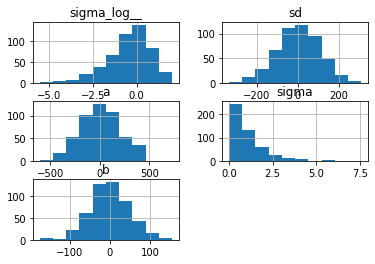

In [28]:
df_man = pd.DataFrame()
for x in prior_gender_man_model.keys():
  if x not in ['vot', 'vot_hat']:
    df_man[x] = prior_gender_man_model[x]

df_man.hist()

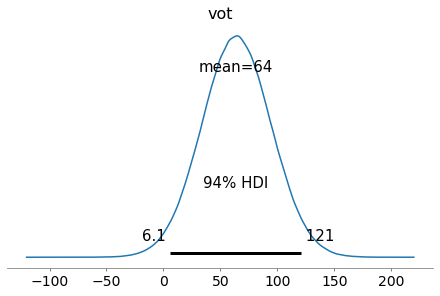

In [29]:
az.plot_posterior(posterior_gender_man)

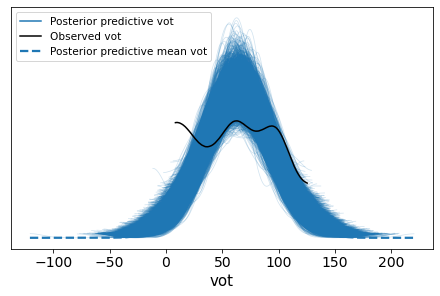

In [31]:
az.plot_ppc(gender_vot_model_man ,group='posterior')

**Its not fitting perfecty to model there should be modification for sample ranges.**

## English Model

In [33]:
with pm.Model() as english_gender_model:
  b = pm.Normal("b", 0., 50.)
  sd = pm.Normal("sd", 0., 100.)
  a = pm.Normal("a", 0, 200.)
  sigma = pm.Exponential("sigma", 1)

  vot_hat = pm.Deterministic("vot_hat", a + b*datE_Renamed["gender"])
  vot = pm.Normal("vot", mu=vot_hat, sigma=sigma, observed=datE_Renamed["VOT"])

  trace_gender_en_sample = pm.sample(draws=2000, tune=1000, chains=4)
  prior_gender_en_model = pm.sample_prior_predictive()
  posterior_gender_en = pm.sample_posterior_predictive(trace_gender_en_sample)

  gender_vot_model_en = az.from_pymc3(
    trace=trace_gender_en_sample,
    prior=prior_gender_en_model,
    posterior_predictive=posterior_gender_en,
    dims=genderModel
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, sd, b]
Sampling chain 3, 0 divergences: 100%|██████████| 3000/3000 [00:19<00:00, 150.96it/s]
The acceptance probability does not match the target. It is 0.9002857242582624, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9248361485397482, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 8000/8000 [00:10<00:00, 735.89it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4a80b4cf8>,
      dtype=object)

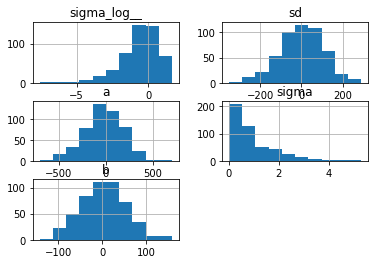

In [15]:
df_man = pd.DataFrame()
for x in prior_gender_en_model.keys():
  if x not in ['vot', 'vot_hat']:
    df_man[x] = prior_gender_en_model[x]

df_man.hist()

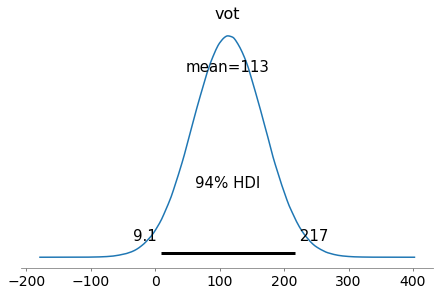

In [16]:
az.plot_posterior(posterior_gender_en)

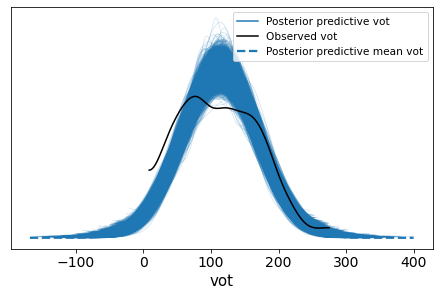

In [34]:
az.plot_ppc(gender_vot_model_en ,group='posterior')

**HDI ratio is good our range is starting from -100 and fit is not perfect.**

# Question 2

The effect of typical vowel duration on VOT

We will check cross-linguistic difference between Mandarin and English in the gender effect on VOT, and in the effect of vowel duration
on VOT.

## Measurement Mandalin error model

### PreProcess


In [6]:

dataM_EM = datM_Renamed[datM_Renamed["voiceN"]==-1].groupby(["subject"], as_index=False).agg({"vduration":["mean","std","count"], "VOT":["mean","std","count"]})

## create a df template 
dataM_EM_tp = pd.DataFrame()

## set subject
dataM_EM_tp["subject"] = dataM_EM["subject"]

## set mean of vduration
dataM_EM_tp["meanvdur"] =dataM_EM["vduration"]["mean"]

## scale meanvdur 
dataM_EM_tp["cmeanvdur"] = pd.DataFrame(scale(dataM_EM_tp["meanvdur"]))

## set std of vduration
dataM_EM_tp["stdvdur"] = dataM_EM["vduration"]["std"]

## calculate sevdur
dataM_EM_tp["sevdur"] = dataM_EM["vduration"]["std"] / np.sqrt(dataM_EM["vduration"]["count"])

## calculate sevdur / stdvdur
dataM_EM_tp["sestdvdur"] = dataM_EM_tp["sevdur"] / dataM_EM_tp["stdvdur"]

## set mean of VOT
dataM_EM_tp["meanVOT"] = dataM_EM["VOT"]["mean"]

## find std of VOT and divide it
dataM_EM_tp["seVOT"] = dataM_EM["VOT"]["std"] / np.sqrt(dataM_EM["VOT"]["count"])

dataM_EM_tp.head()

,subject,meanvdur,cmeanvdur,stdvdur,sevdur,sestdvdur,meanVOT,seVOT
0,s9gt01fw,231.020801,0.327928,59.078297,18.682198,0.316228,69.852341,9.204850
1,s9gt02fw,247.118195,0.956995,45.371013,14.347574,0.316228,62.855787,9.264652
2,s9gt03fw,224.132314,0.058735,46.636881,14.747877,0.316228,64.484586,12.215414
3,s9gt04fw,249.070203,1.033277,51.795524,16.379183,0.316228,63.331775,11.801162
4,s9gt05fw,224.768456,0.083594,51.704612,16.350434,0.316228,86.741778,10.351585


### Model

In [68]:
vdur_vot_model_dimensions={
    "VOT": ["developer"],
    "cmeanvdur": ["developer"],
    "sevdur": ["developer"]
}

In [69]:
# model for mandarin
with pm.Model() as vdur_vot_model_mn:
  a = pm.Normal("a", 0, 200)
  b = pm.Normal("b", 0, 5)
  bC = pm.Normal("bC", 0, 5)
  sigma = pm.Exponential("sigma", 1)

  mvot_hat = pm.Deterministic("mvot_hat", a + b*dataM_EM_tp["cmeanvdur"] + bC*dataM_EM_tp["sevdur"])
  mvot = pm.Normal("mvot", mu=mvot_hat, sigma=sigma, observed=dataM_EM_tp["meanVOT"])

  trace_vdur_vot_model_mn = pm.sample(draws=2000, tune=1000, chains=4)
  prior_vdur_vot_model_mn = pm.sample_prior_predictive()
  posterior_vdur_vot_model_mn = pm.sample_posterior_predictive(trace_vdur_vot_model_mn)

  az_vdur_vot_model_mn = az.from_pymc3(
    trace=trace_vdur_vot_model_mn,
    prior=prior_vdur_vot_model_mn,
    posterior_predictive=posterior_vdur_vot_model_mn,
    dims=vdur_vot_model_dimensions
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bC, b, a]
100%|██████████| 8000/8000 [00:10<00:00, 748.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2091bb278>,
      dtype=object)

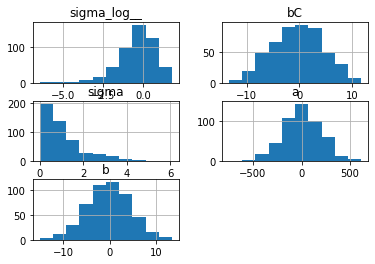

In [38]:
df_mn = pd.DataFrame()
for x in prior_vdur_vot_model_mn.keys():
  if x not in ['mvot', 'mvot_hat']:
    df_mn[x] = prior_vdur_vot_model_mn[x]

df_mn.hist()

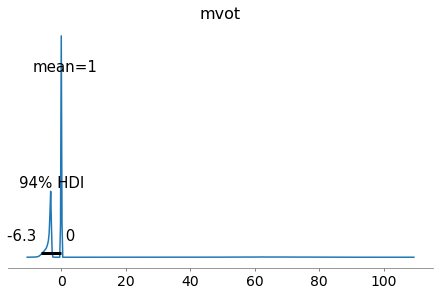

In [39]:
az.plot_posterior(posterior_vdur_vot_model_mn)

## Measurement English error model

### PreProcess

In [7]:

dataE_EM = datE_Renamed[datE_Renamed["voiceN"]==-1].groupby(["subject"], as_index=False).agg({"vduration":["mean","std","count"], "VOT":["mean","std","count"]})

## create a df template 
dataE_EM_tp = pd.DataFrame()

## set subject
dataE_EM_tp["subject"] = dataE_EM["subject"]

## set mean of vduration
dataE_EM_tp["meanvdur"] =dataE_EM["vduration"]["mean"]

## scale meanvdur "
dataE_EM_tp["cmeanvdur"] = pd.DataFrame(scale(dataE_EM_tp["meanvdur"]))

## set std of vduration
dataE_EM_tp["stdvdur"] = dataE_EM["vduration"]["std"]

## calculate sevdur
dataE_EM_tp["sevdur"] = dataE_EM["vduration"]["std"] / np.sqrt(dataE_EM["vduration"]["count"])

## calculate sevdur / stdvdur
dataE_EM_tp["sestdvdur"] = dataE_EM_tp["sevdur"] / dataE_EM_tp["stdvdur"]

## set mean of VOT
dataE_EM_tp["meanVOT"] = dataE_EM["VOT"]["mean"]

## find std of VOT and divide it
dataE_EM_tp["seVOT"] = dataE_EM["VOT"]["std"] / np.sqrt(dataE_EM["VOT"]["count"])

dataE_EM_tp.head()

,subject,meanvdur,cmeanvdur,stdvdur,sevdur,sestdvdur,meanVOT,seVOT
0,e9gt01mw,243.755361,0.481540,94.035981,14.510067,0.154303,123.105735,6.794593
1,e9gt02mw,195.465718,-1.729525,64.719659,10.107513,0.156174,91.128550,7.471602
2,e9gt03fw,240.297155,0.323197,80.998667,12.498366,0.154303,104.504371,7.875319
3,e9gt04mw,193.154420,-1.835354,69.037248,10.652679,0.154303,129.196421,9.516746
4,e9gt05fw,272.153314,1.781813,96.716397,14.923664,0.154303,108.714463,6.299116


### English

In [72]:
# model for english
with pm.Model() as vdur_vot_model_en:
  a = pm.Normal("a", 0, 200)
  b = pm.Normal("b", 0, 5)
  bC = pm.Normal("bC", 0, 5)
  sigma = pm.Exponential("sigma", 1)

  mvot_hat = pm.Deterministic("mvot_hat", a + b*dataE_EM_tp["cmeanvdur"] + bC*dataE_EM_tp["sevdur"])
  mvot = pm.Normal("mvot", mu=mvot_hat, sigma=sigma, observed=dataE_EM_tp["meanVOT"])

  trace_vdur_vot_model_en = pm.sample(draws=2000, tune=1000, chains=4)
  prior_vdur_vot_model_en = pm.sample_prior_predictive()
  posterior_vdur_vot_model_en = pm.sample_posterior_predictive(trace_vdur_vot_model_en)

  az_vdur_vot_model_en = az.from_pymc3(
    trace=trace_vdur_vot_model_en,
    prior=prior_vdur_vot_model_en,
    posterior_predictive=posterior_vdur_vot_model_en,
    dims=vdur_vot_model_dimensions
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bC, b, a]
Sampling chain 3, 0 divergences: 100%|██████████| 3000/3000 [00:13<00:00, 225.34it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 8000/8000 [00:10<00:00, 751.07it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2090fcf98>,
      dtype=object)

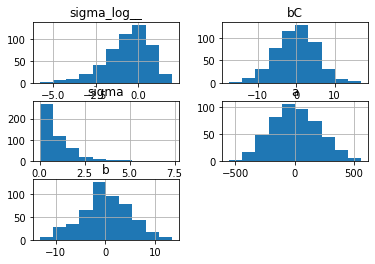

In [73]:
df_en = pd.DataFrame()
for x in prior_vdur_vot_model_en.keys():
  if x not in ['mvot', 'mvot_hat']:
    df_en[x] = prior_vdur_vot_model_en[x]

df_en.hist()

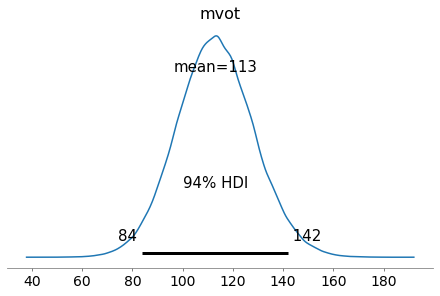

In [74]:
az.plot_posterior(posterior_vdur_vot_model_en)

# Question 3

Cross-linguistic differences between Mandarin and English for questions 1 and 2



## Preprocess for stops

We need to modify our dataframes add some fields and create a common to df to represent English and Mandarin together

### Engilish


In [29]:
## add extra columns 
dataE_EM_tp_s= datE_Renamed.copy()

dataE_EM_tp_s["lang"] = -0.5

english="E"
dataE_EM_tp_s["subject"] = english + datE_Renamed["subject"]


dataE_EM_tp_s.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
2,10,49,Ee9gt01mw,m,-0.5,49.860658,267.595631,-1,-0.5
3,10,41,Ee9gt01mw,m,-0.5,56.444342,302.313780,-1,-0.5
4,10,30,Ee9gt01mw,m,-0.5,59.868863,432.950305,-1,-0.5
5,10,39,Ee9gt01mw,m,-0.5,69.763520,156.066285,-1,-0.5
8,10,54,Ee9gt01mw,m,-0.5,88.775660,219.483993,-1,-0.5


### Mandarin

In [28]:
## add extra columns 
dataM_EM_tp_s= datM_Renamed.copy()

dataM_EM_tp_s["lang"] = -0.5

mandarin="M"
dataM_EM_tp_s["subject"] = mandarin + datM_Renamed["subject"]


dataM_EM_tp_s.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
0,0,14,Ms9gt01fw,f,0.5,24.138644,173.848081,-1,-0.5
3,0,19,Ms9gt01fw,f,0.5,61.244091,255.367214,-1,-0.5
4,0,12,Ms9gt01fw,f,0.5,63.784175,266.556838,-1,-0.5
6,0,11,Ms9gt01fw,f,0.5,94.100283,195.263651,-1,-0.5
8,0,17,Ms9gt01fw,f,0.5,101.468401,212.920039,-1,-0.5


### Concat dataframes

In [37]:
dataEM_s = pd.concat([dataE_EM_tp_s, dataM_EM_tp_s])
dataEM_s = dataEM_s.fillna(0)
dataEM_s.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
2,10,49,Ee9gt01mw,m,-0.5,49.860658,267.595631,-1,-0.5
3,10,41,Ee9gt01mw,m,-0.5,56.444342,302.313780,-1,-0.5
4,10,30,Ee9gt01mw,m,-0.5,59.868863,432.950305,-1,-0.5
5,10,39,Ee9gt01mw,m,-0.5,69.763520,156.066285,-1,-0.5
8,10,54,Ee9gt01mw,m,-0.5,88.775660,219.483993,-1,-0.5


## Preprocess for voices

### English

In [43]:
dataE_EM_tp_v= datE_Renamed.copy()

dataE_EM_tp_v["lang"] = -0.5

english="E"
dataE_EM_tp_v["subject"] = english + dataE_EM_tp["subject"]


dataE_EM_tp_v.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
2,10,49,Ee9gt03fw,m,-0.5,49.860658,267.595631,-1,-0.5
3,10,41,Ee9gt04mw,m,-0.5,56.444342,302.313780,-1,-0.5
4,10,30,Ee9gt05fw,m,-0.5,59.868863,432.950305,-1,-0.5
5,10,39,Ee9gt06mw,m,-0.5,69.763520,156.066285,-1,-0.5
8,10,54,Ee9gt09fw,m,-0.5,88.775660,219.483993,-1,-0.5


### Mandarin

In [44]:
dataM_EM_tp_v= datM_Renamed.copy()

dataM_EM_tp_v["lang"] = -0.5

mandarin="M"
dataM_EM_tp_v["subject"] = mandarin + datM_Renamed["subject"]


dataM_EM_tp_v.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
0,0,14,Ms9gt01fw,f,0.5,24.138644,173.848081,-1,-0.5
3,0,19,Ms9gt01fw,f,0.5,61.244091,255.367214,-1,-0.5
4,0,12,Ms9gt01fw,f,0.5,63.784175,266.556838,-1,-0.5
6,0,11,Ms9gt01fw,f,0.5,94.100283,195.263651,-1,-0.5
8,0,17,Ms9gt01fw,f,0.5,101.468401,212.920039,-1,-0.5


### Concat dataframes

In [45]:
dataEM_v = pd.concat([dataE_EM_tp_v, dataM_EM_tp_v])

dataEM_v = dataEM_v.fillna(0)

dataEM_v.head()

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
2,10,49,Ee9gt03fw,m,-0.5,49.860658,267.595631,-1,-0.5
3,10,41,Ee9gt04mw,m,-0.5,56.444342,302.313780,-1,-0.5
4,10,30,Ee9gt05fw,m,-0.5,59.868863,432.950305,-1,-0.5
5,10,39,Ee9gt06mw,m,-0.5,69.763520,156.066285,-1,-0.5
8,10,54,Ee9gt09fw,m,-0.5,88.775660,219.483993,-1,-0.5


## Model For Stop

In [31]:
lang_vot_model_dimensions={
    "VOT": ["developer"],
    "lang": ["developer"],
    "gender": ["developer"]
}

vdur_lang_vot_model_dimensions={
    "VOT": ["developer"],
    "cmeanvdur": ["developer"],
    "lang": ["developer"]
}

In [32]:
dataEM_s

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
2,10,49,Ee9gt01mw,m,-0.5,49.860658,267.595631,-1,-0.5
3,10,41,Ee9gt01mw,m,-0.5,56.444342,302.313780,-1,-0.5
4,10,30,Ee9gt01mw,m,-0.5,59.868863,432.950305,-1,-0.5
5,10,39,Ee9gt01mw,m,-0.5,69.763520,156.066285,-1,-0.5
8,10,54,Ee9gt01mw,m,-0.5,88.775660,219.483993,-1,-0.5
...,...,...,...,...,...,...,...,...,...
390,19,14,Ms9gt20mw,m,-0.5,14.117671,164.732597,-1,-0.5
394,19,12,Ms9gt20mw,m,-0.5,60.333644,294.027431,-1,-0.5
395,19,16,Ms9gt20mw,m,-0.5,76.351775,274.520330,-1,-0.5
396,19,19,Ms9gt20mw,m,-0.5,85.876305,256.281047,-1,-0.5


In [38]:
with pm.Model() as lang_vot_model:
  a = pm.Normal("a", 0, 200)
  b = pm.Normal("b", 0, 50)
  bC = pm.Normal("bC", 0, 50)
  sigma = pm.Exponential("sigma", 1)

  vot_hat = pm.Deterministic("vot_hat", a + b*dataEM_s["gender"]*dataEM_s["lang"] + bC*dataEM_s["lang"])
  vot = pm.Normal("vot", mu=vot_hat, sigma=sigma, observed=dataEM_s["VOT"])

  trace_lang_vot_model = pm.sample(draws=2000, tune=1000, chains=4)
  prior_lang_vot_model = pm.sample_prior_predictive()
  posterior_lang_vot_model = pm.sample_posterior_predictive(trace_lang_vot_model)

  az_lang_vot_model = az.from_pymc3(
    trace=trace_lang_vot_model,
    prior=prior_lang_vot_model,
    posterior_predictive=posterior_lang_vot_model,
    dims=lang_vot_model_dimensions
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bC, b, a]
Sampling chain 3, 0 divergences: 100%|██████████| 3000/3000 [00:28<00:00, 105.33it/s]
The acceptance probability does not match the target. It is 0.8853038706611099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986599032595294, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 8000/8000 [00:10<00:00, 761.41it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8c1ab8f98>,
      dtype=object)

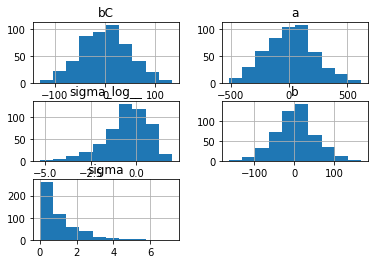

In [39]:
df = pd.DataFrame()
for x in prior_lang_vot_model.keys():
  if x not in ['vot', 'vot_hat']:
    df[x] = prior_lang_vot_model[x]

df.hist()

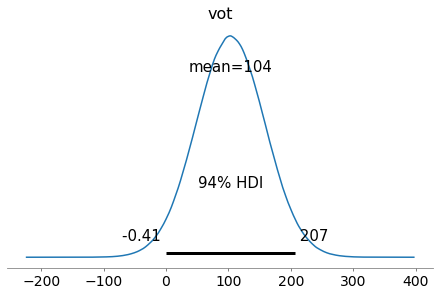

In [40]:
az.plot_posterior(posterior_lang_vot_model)

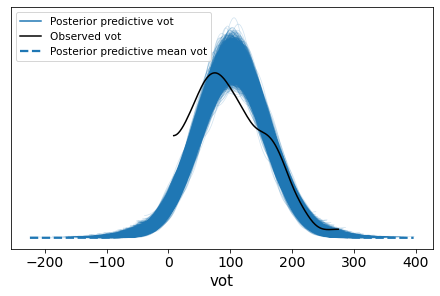

In [41]:
az.plot_ppc(az_lang_vot_model ,group='posterior')

**It fits pretty good with our distrubution.**

## Model for voices

In [47]:
dataEM_v

,genSubN,worldBetN,subject,genderfact,gender,VOT,vduration,voiceN,lang
2,10,49,Ee9gt03fw,m,-0.5,49.860658,267.595631,-1,-0.5
3,10,41,Ee9gt04mw,m,-0.5,56.444342,302.313780,-1,-0.5
4,10,30,Ee9gt05fw,m,-0.5,59.868863,432.950305,-1,-0.5
5,10,39,Ee9gt06mw,m,-0.5,69.763520,156.066285,-1,-0.5
8,10,54,Ee9gt09fw,m,-0.5,88.775660,219.483993,-1,-0.5
...,...,...,...,...,...,...,...,...,...
390,19,14,Ms9gt20mw,m,-0.5,14.117671,164.732597,-1,-0.5
394,19,12,Ms9gt20mw,m,-0.5,60.333644,294.027431,-1,-0.5
395,19,16,Ms9gt20mw,m,-0.5,76.351775,274.520330,-1,-0.5
396,19,19,Ms9gt20mw,m,-0.5,85.876305,256.281047,-1,-0.5


In [48]:
with pm.Model() as vdur_lang_vot_model:
  a = pm.Normal("a", 0, 200)
  b = pm.Normal("b", 0, 50)
  bC = pm.Normal("bC", 0, 50)
  sigma = pm.Exponential("sigma", 1)

  vot_hat = pm.Deterministic("vot_hat", a + b*dataEM_v["gender"]*dataEM_v["lang"] + bC*dataEM_v["lang"])
  vot = pm.Normal("vot", mu=vot_hat, sigma=sigma, observed=dataEM_v["VOT"])

  trace_vdur_lang_vot_model = pm.sample(draws=2000, tune=1000, chains=4)
  prior_vdur_lang_vot_model = pm.sample_prior_predictive()
  posterior_vdur_lang_vot_model = pm.sample_posterior_predictive(trace_vdur_lang_vot_model)

  az_vdur_lang_vot_model = az.from_pymc3(
    trace=trace_vdur_lang_vot_model,
    prior=prior_vdur_lang_vot_model,
    posterior_predictive=posterior_vdur_lang_vot_model,
    dims=vdur_lang_vot_model_dimensions
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bC, b, a]
Sampling chain 3, 0 divergences: 100%|██████████| 3000/3000 [00:23<00:00, 128.96it/s]
The acceptance probability does not match the target. It is 0.9078988991772394, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973018485164445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906464614510369, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 8000/8000 [00:10<00:00, 772.86it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8b21dc7b8>,
      dtype=object)

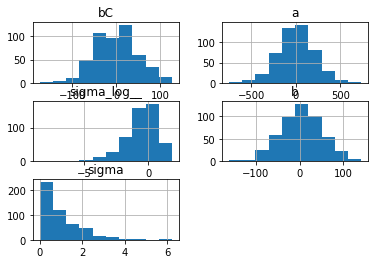

In [49]:
df = pd.DataFrame()
for x in prior_vdur_lang_vot_model.keys():
  if x not in ['vot', 'vot_hat']:
    df[x] = prior_vdur_lang_vot_model[x]

df.hist()

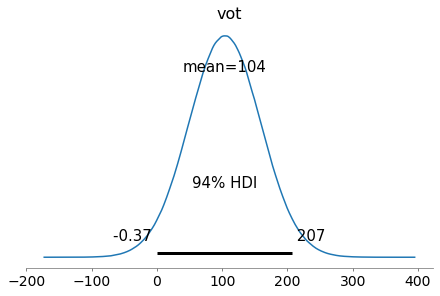

In [50]:
az.plot_posterior(posterior_vdur_lang_vot_model)

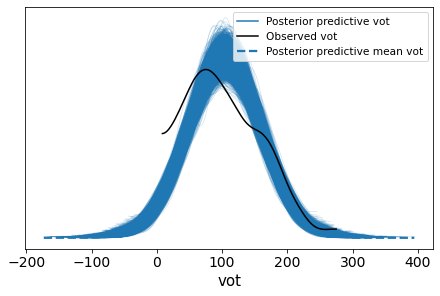

In [51]:
az.plot_ppc(az_vdur_lang_vot_model ,group='posterior')